Train shape: (75000, 4)
Test shape: (75000, 3)

Train columns: ['sample_id', 'catalog_content', 'image_link', 'price']

Missing values:
sample_id          0
catalog_content    0
image_link         0
price              0
dtype: int64

Price statistics:
count    75000.000000
mean        23.647654
std         33.376932
min          0.130000
25%          6.795000
50%         14.000000
75%         28.625000
max       2796.000000
Name: price, dtype: float64


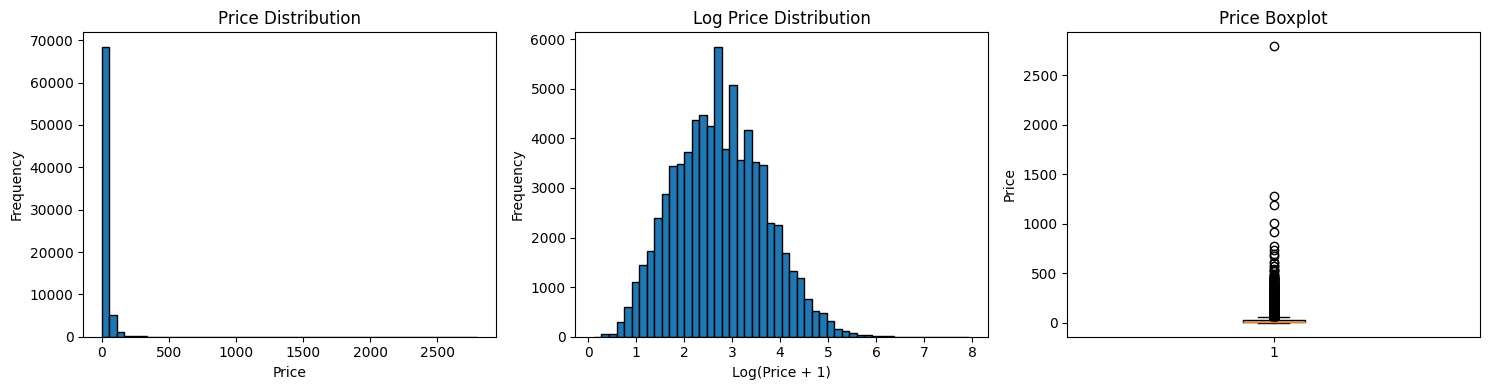


Sample catalog_content:

--- Sample 1 ---
Price: $4.890000000000001
Content: Item Name: La Victoria Green Taco Sauce Mild, 12 Ounce (Pack of 6)
Value: 72.0
Unit: Fl Oz
...

--- Sample 2 ---
Price: $13.12
Content: Item Name: Salerno Cookies, The Original Butter Cookies, 8 Ounce (Pack of 4)
Bullet Point 1: Original Butter Cookies: Classic butter cookies made with real butter
Bullet Point 2: Variety Pack: Include...

--- Sample 3 ---
Price: $1.97
Content: Item Name: Bear Creek Hearty Soup Bowl, Creamy Chicken with Rice, 1.9 Ounce (Pack of 6)
Bullet Point 1: Loaded with hearty long grain wild rice and vegetables
Bullet Point 2: Full of hearty goodness
B...


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

train_df = pd.read_csv('/kaggle/input/student-resource/student_resource/dataset/train.csv')
test_df = pd.read_csv('/kaggle/input/student-resource/student_resource/dataset/test.csv')

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print("\nTrain columns:", train_df.columns.tolist())
print("\nMissing values:")
print(train_df.isnull().sum())

print("\nPrice statistics:")
print(train_df['price'].describe())

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(train_df['price'], bins=50, edgecolor='black')
axes[0].set_title('Price Distribution')
axes[0].set_xlabel('Price')
axes[0].set_ylabel('Frequency')

axes[1].hist(np.log1p(train_df['price']), bins=50, edgecolor='black')
axes[1].set_title('Log Price Distribution')
axes[1].set_xlabel('Log(Price + 1)')
axes[1].set_ylabel('Frequency')

axes[2].boxplot(train_df['price'])
axes[2].set_title('Price Boxplot')
axes[2].set_ylabel('Price')

plt.tight_layout()
plt.show()

print("\nSample catalog_content:")
for i in range(3):
    print(f"\n--- Sample {i+1} ---")
    print(f"Price: ${train_df.iloc[i]['price']}")
    print(f"Content: {train_df.iloc[i]['catalog_content'][:200]}...")

Text length statistics:
count    75000.000000
mean       907.884413
std        852.894941
min         31.000000
25%        250.000000
50%        642.000000
75%       1279.000000
max       7893.000000
Name: text_length, dtype: float64


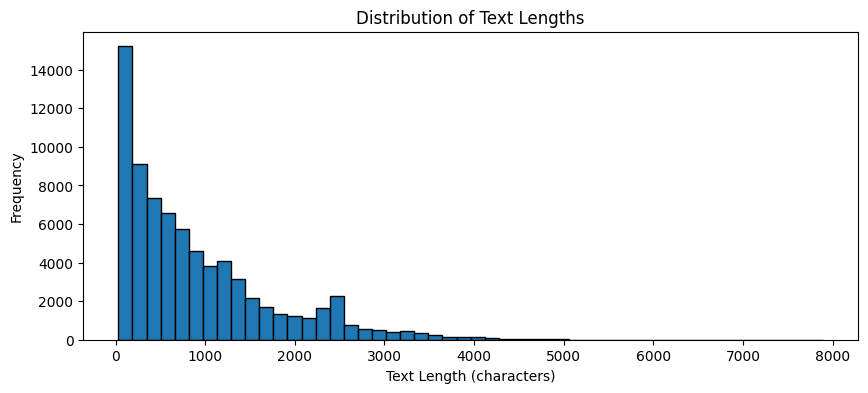


Log price statistics:
count    75000.000000
mean         2.739217
std          0.942032
min          0.122218
25%          2.053483
50%          2.708050
75%          3.388619
max          7.936303
Name: log_price, dtype: float64

Sample cleaned text:
Item Name: La Victoria Green Taco Sauce Mild, 12 Ounce (Pack of 6) Value: 72.0 Unit: Fl Oz


In [ ]:
import re

def clean_text(text):
    if pd.isna(text):
        return ""
    text = str(text)
    text = text.replace('\n', ' ').replace('\r', ' ')
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text

train_df['clean_text'] = train_df['catalog_content'].apply(clean_text)
test_df['clean_text'] = test_df['catalog_content'].apply(clean_text)

train_df['text_length'] = train_df['clean_text'].str.len()
test_df['text_length'] = test_df['clean_text'].str.len()

print("Text length statistics:")
print(train_df['text_length'].describe())

plt.figure(figsize=(10, 4))
plt.hist(train_df['text_length'], bins=50, edgecolor='black')
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length (characters)')
plt.ylabel('Frequency')
plt.show()

train_df['log_price'] = np.log1p(train_df['price'])

print("\nLog price statistics:")
print(train_df['log_price'].describe())

print("\nSample cleaned text:")
print(train_df.iloc[0]['clean_text'][:300])

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch

MODEL_NAME = 'sentence-transformers/all-MiniLM-L6-v2'
MAX_LENGTH = 128

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
base_model = AutoModel.from_pretrained(MODEL_NAME)

print(f"Model loaded: {MODEL_NAME}")
print(f"Max length: {MAX_LENGTH}")

sample_texts = train_df['clean_text'].head(3).tolist()
sample_encodings = tokenizer(
    sample_texts,
    max_length=MAX_LENGTH,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)

print("\nSample encoding shapes:")
print(f"input_ids: {sample_encodings['input_ids'].shape}")
print(f"attention_mask: {sample_encodings['attention_mask'].shape}")

with torch.no_grad():
    outputs = base_model(**sample_encodings)
    embeddings = outputs.last_hidden_state[:, 0, :]

print(f"\nEmbedding shape: {embeddings.shape}")
print(f"Embedding dimension: {embeddings.shape[1]}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Model loaded: sentence-transformers/all-MiniLM-L6-v2
Max length: 128

Sample encoding shapes:
input_ids: torch.Size([3, 128])
attention_mask: torch.Size([3, 128])

Embedding shape: torch.Size([3, 384])
Embedding dimension: 384


In [ ]:
from torch.utils.data import Dataset, DataLoader

class ProductPriceDataset(Dataset):
    def __init__(self, texts, prices, tokenizer, max_length):
        self.texts = texts
        self.prices = prices
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])

        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        item = {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

        if self.prices is not None:
            item['price'] = torch.tensor(self.prices[idx], dtype=torch.float)

        return item

from sklearn.model_selection import train_test_split

train_texts, val_texts, train_prices, val_prices = train_test_split(
    train_df['clean_text'].values,
    train_df['log_price'].values,
    test_size=0.1,
    random_state=42
)

print(f"Train samples: {len(train_texts)}")
print(f"Val samples: {len(val_texts)}")

train_dataset = ProductPriceDataset(train_texts, train_prices, tokenizer, MAX_LENGTH)
val_dataset = ProductPriceDataset(val_texts, val_prices, tokenizer, MAX_LENGTH)

BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\nTrain batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

sample_batch = next(iter(train_loader))
print(f"\nSample batch shapes:")
print(f"input_ids: {sample_batch['input_ids'].shape}")
print(f"attention_mask: {sample_batch['attention_mask'].shape}")
print(f"price: {sample_batch['price'].shape}")

Train samples: 67500
Val samples: 7500

Train batches: 2110
Val batches: 235

Sample batch shapes:
input_ids: torch.Size([32, 128])
attention_mask: torch.Size([32, 128])
price: torch.Size([32])


In [ ]:
import torch.nn as nn

class PricePredictionModel(nn.Module):
    def __init__(self, transformer_model, hidden_size=384, dropout=0.2):
        super(PricePredictionModel, self).__init__()
        self.transformer = transformer_model
        self.regressor = nn.Sequential(
            nn.Linear(hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 1)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        cls_embedding = outputs.last_hidden_state[:, 0, :]
        price_pred = self.regressor(cls_embedding)
        return price_pred.squeeze()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = PricePredictionModel(base_model).to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

print("\nModel architecture:")
print(model)

Using device: cuda

Total parameters: 22,844,801
Trainable parameters: 22,844,801

Model architecture:
PricePredictionModel(
  (transformer): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 384, padding_idx=0)
      (position_embeddings): Embedding(512, 384)
      (token_type_embeddings): Embedding(2, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in

In [ ]:
def smape_loss(pred, target):
    epsilon = 1e-8
    numerator = torch.abs(pred - target)
    denominator = (torch.abs(target) + torch.abs(pred)) / 2 + epsilon
    return torch.mean(numerator / denominator)

def calculate_smape(pred, target):
    epsilon = 1e-8
    numerator = np.abs(pred - target)
    denominator = (np.abs(target) + np.abs(pred)) / 2 + epsilon
    return np.mean(numerator / denominator) * 100

from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

EPOCHS = 5
LEARNING_RATE = 2e-5
WARMUP_STEPS = 500

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=WARMUP_STEPS,
    num_training_steps=total_steps
)

print(f"Training configuration:")
print(f"Epochs: {EPOCHS}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Total training steps: {total_steps}")
print(f"Warmup steps: {WARMUP_STEPS}")

sample_pred = torch.tensor([5.0, 4.5, 6.0])
sample_target = torch.tensor([5.5, 4.0, 6.2])
sample_loss = smape_loss(sample_pred, sample_target)
print(f"\nSample SMAPE loss: {sample_loss.item():.4f}")

2025-10-12 10:58:38.627405: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760266718.766355     114 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760266718.806852     114 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Training configuration:
Epochs: 5
Learning rate: 2e-05
Batch size: 32
Total training steps: 10550
Warmup steps: 500

Sample SMAPE loss: 0.0819


In [ ]:
from tqdm import tqdm

def train_epoch(model, loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    predictions = []
    actuals = []

    for batch in tqdm(loader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        prices = batch['price'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask)
        loss = smape_loss(outputs, prices)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        predictions.extend(outputs.detach().cpu().numpy())
        actuals.extend(prices.detach().cpu().numpy())

    avg_loss = total_loss / len(loader)
    smape_score = calculate_smape(np.array(predictions), np.array(actuals))

    return avg_loss, smape_score

def validate_epoch(model, loader, device):
    model.eval()
    total_loss = 0
    predictions = []
    actuals = []

    with torch.no_grad():
        for batch in tqdm(loader, desc="Validation"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            prices = batch['price'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = smape_loss(outputs, prices)

            total_loss += loss.item()
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(prices.cpu().numpy())

    avg_loss = total_loss / len(loader)
    smape_score = calculate_smape(np.array(predictions), np.array(actuals))

    return avg_loss, smape_score, predictions, actuals

history = {
    'train_loss': [],
    'train_smape': [],
    'val_loss': [],
    'val_smape': []
}

best_val_smape = float('inf')
patience = 3
patience_counter = 0

print("Starting training...\n")

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")

    train_loss, train_smape = train_epoch(model, train_loader_weighted, optimizer, scheduler, device)
    val_loss, val_smape, val_preds, val_actuals = validate_epoch(model, val_loader, device)

    history['train_loss'].append(train_loss)
    history['train_smape'].append(train_smape)
    history['val_loss'].append(val_loss)
    history['val_smape'].append(val_smape)

    print(f"Train Loss: {train_loss:.4f} | Train SMAPE: {train_smape:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val SMAPE: {val_smape:.2f}%\n")

    if val_smape < best_val_smape:
        best_val_smape = val_smape
        torch.save(model.state_dict(), 'best_model.pt')
        print(f"Model saved! Best Val SMAPE: {best_val_smape:.2f}%\n")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break

print(f"Training completed! Best Val SMAPE: {best_val_smape:.2f}%")

Starting training...

Epoch 1/5


Validation: 100%|██████████| 235/235 [00:13<00:00, 18.01it/s]


Train Loss: 0.2538 | Train SMAPE: 25.38%
Val Loss: 0.2130 | Val SMAPE: 21.29%

Model saved! Best Val SMAPE: 21.29%

Epoch 2/5


Training:  32%|███▏      | 757/2344 [01:39<03:28,  7.62it/s]


KeyboardInterrupt: 

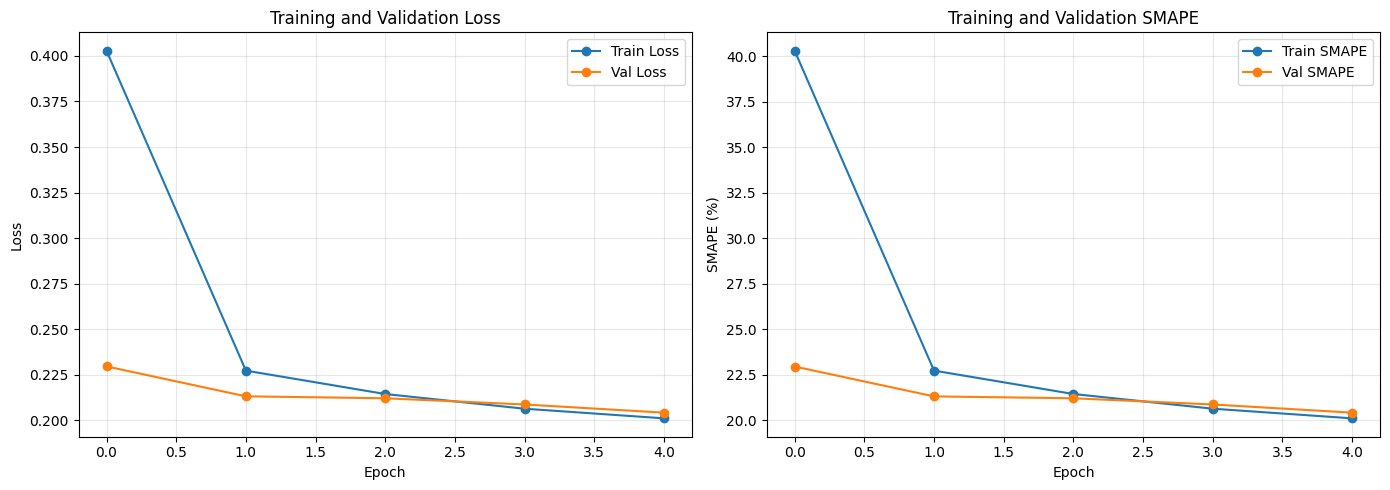

Validation: 100%|██████████| 235/235 [00:13<00:00, 17.53it/s]


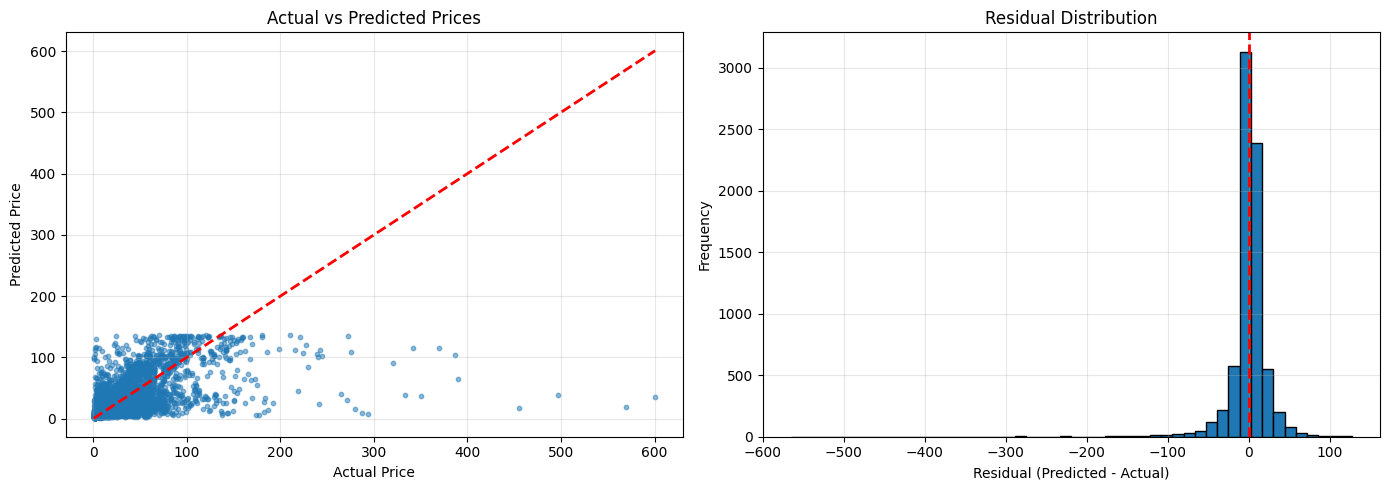

Prediction Statistics (Original Scale):
Mean Absolute Error: $12.74
Median Absolute Error: $6.12
RMSE: $26.42


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='o')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history['train_smape'], label='Train SMAPE', marker='o')
axes[1].plot(history['val_smape'], label='Val SMAPE', marker='o')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('SMAPE (%)')
axes[1].set_title('Training and Validation SMAPE')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

model.load_state_dict(torch.load('best_model.pt'))
_, _, val_preds, val_actuals = validate_epoch(model, val_loader, device)

val_preds_original = np.expm1(val_preds)
val_actuals_original = np.expm1(val_actuals)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(val_actuals_original, val_preds_original, alpha=0.5, s=10)
axes[0].plot([val_actuals_original.min(), val_actuals_original.max()],
             [val_actuals_original.min(), val_actuals_original.max()],
             'r--', lw=2)
axes[0].set_xlabel('Actual Price')
axes[0].set_ylabel('Predicted Price')
axes[0].set_title('Actual vs Predicted Prices')
axes[0].grid(True, alpha=0.3)

residuals = val_preds_original - val_actuals_original
axes[1].hist(residuals, bins=50, edgecolor='black')
axes[1].set_xlabel('Residual (Predicted - Actual)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Residual Distribution')
axes[1].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Prediction Statistics (Original Scale):")
print(f"Mean Absolute Error: ${np.mean(np.abs(residuals)):.2f}")
print(f"Median Absolute Error: ${np.median(np.abs(residuals)):.2f}")
print(f"RMSE: ${np.sqrt(np.mean(residuals**2)):.2f}")

Sample test shape: (100, 3)
Sample test out shape: (100, 2)

Sample test columns: ['sample_id', 'catalog_content', 'image_link']
Sample test out columns: ['sample_id', 'price']

Merged shape: (100, 4)
Missing prices: 0


Predicting on sample test: 100%|██████████| 4/4 [00:00<00:00, 16.86it/s]
/tmp/ipykernel_114/2728044041.py:137: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_stats = error_by_price.groupby('price_bin')['percentage_error'].mean().sort_index()



SAMPLE TEST RESULTS
SMAPE Score: 106.16%

Additional Metrics:
MAE: $38.48
RMSE: $47.14
MAPE: 148.76%

Prediction Statistics:
Min Predicted: $2.50
Max Predicted: $81.93
Mean Predicted: $20.04
Median Predicted: $14.87

Actual Statistics:
Min Actual: $0.54
Max Actual: $99.73
Mean Actual: $51.21
Median Actual: $53.22

Top 10 Worst Predictions:
 sample_id  actual_price  predicted_price  absolute_error  percentage_error
     76467     97.409171         3.063837       94.345334         96.854673
    154665     97.868203         4.659172       93.209032         95.239341
    164102     95.699457         6.282783       89.416674         93.434881
    220124     94.657779         6.332009       88.325769         93.310630
    140742     96.725401         9.331022       87.394379         90.353080
     85054     91.578039         5.717178       85.860861         93.757043
     33905     93.261168         9.236472       84.024695         90.096122
    287788     99.630252        20.062725       7

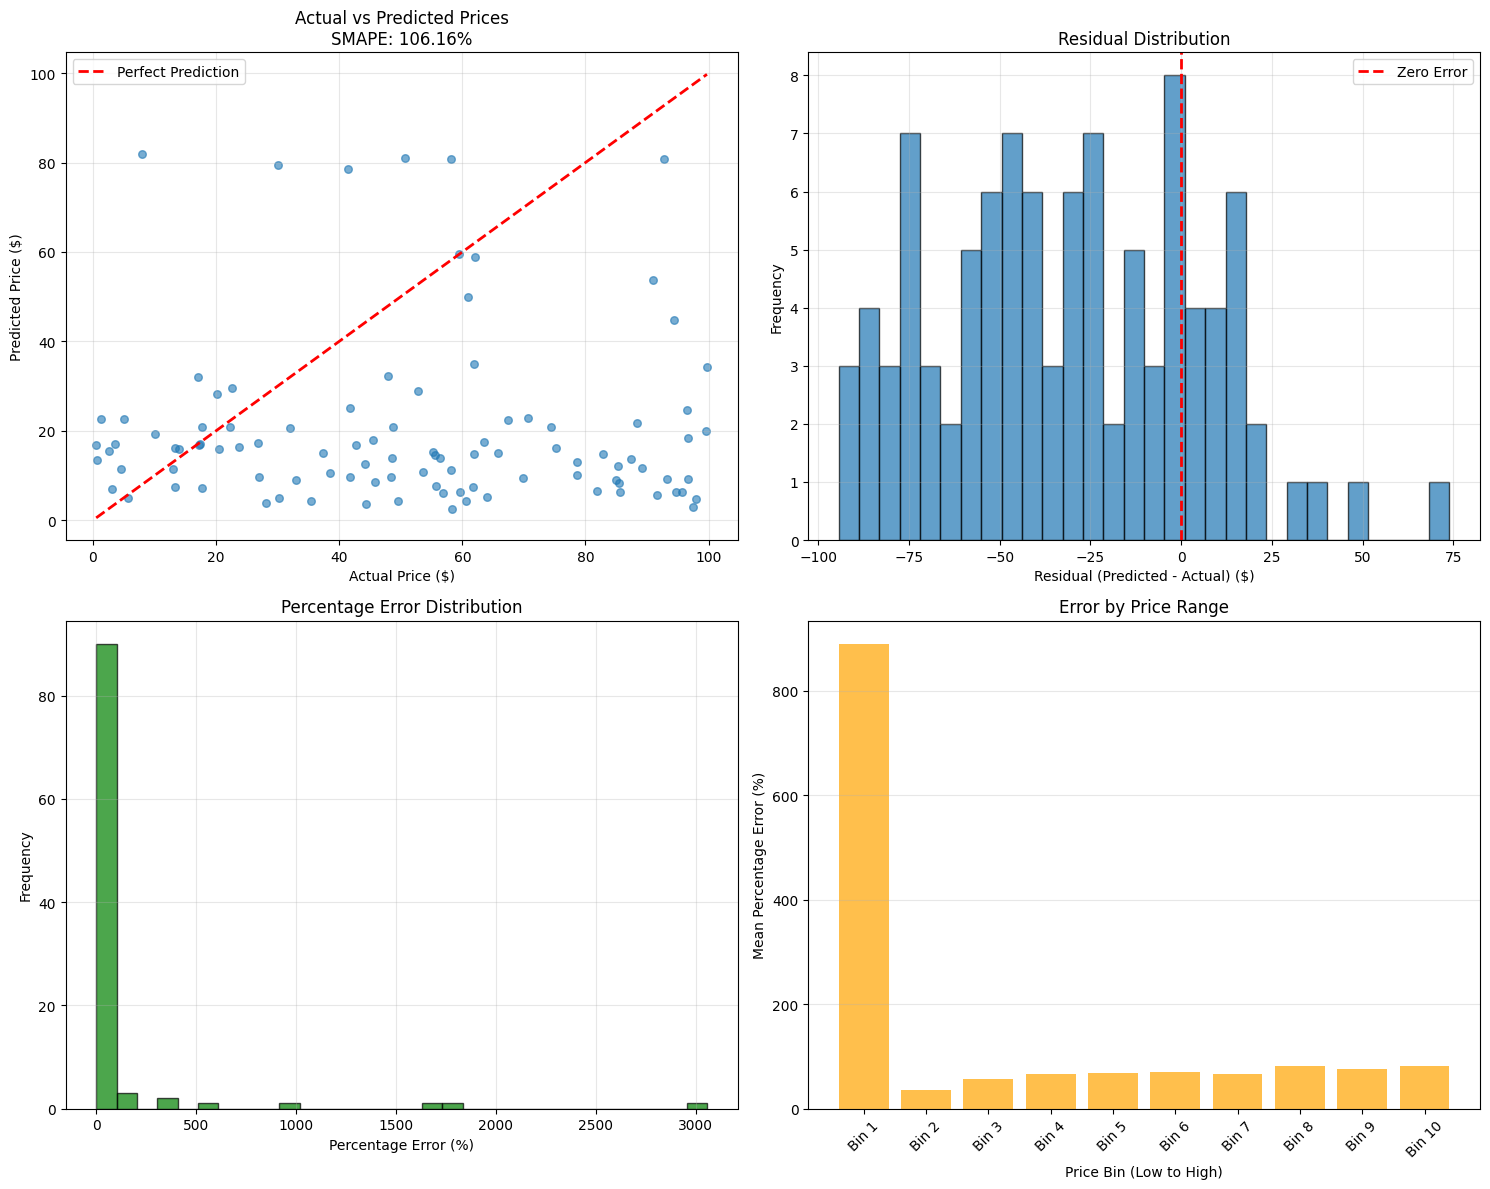


✓ Detailed comparison saved to 'sample_test_comparison.csv'


In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

sample_test_df = pd.read_csv('/kaggle/input/student-resource/student_resource/dataset/sample_test.csv')
sample_test_out_df = pd.read_csv('/kaggle/input/student-resource/student_resource/dataset/sample_test_out.csv')

print(f"Sample test shape: {sample_test_df.shape}")
print(f"Sample test out shape: {sample_test_out_df.shape}")
print("\nSample test columns:", sample_test_df.columns.tolist())
print("Sample test out columns:", sample_test_out_df.columns.tolist())

sample_test_df = sample_test_df.merge(sample_test_out_df, on='sample_id', how='left')
print(f"\nMerged shape: {sample_test_df.shape}")
print(f"Missing prices: {sample_test_df['price'].isna().sum()}")

sample_test_df['clean_text'] = sample_test_df['catalog_content'].apply(clean_text)

sample_test_dataset = ProductPriceDataset(
    sample_test_df['clean_text'].values,
    None,
    tokenizer,
    MAX_LENGTH
)

sample_test_loader = DataLoader(sample_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

model.load_state_dict(torch.load('best_model.pt'))
model.eval()

sample_predictions = []

with torch.no_grad():
    for batch in tqdm(sample_test_loader, desc="Predicting on sample test"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids, attention_mask)
        sample_predictions.extend(outputs.cpu().numpy())

sample_predictions = np.array(sample_predictions)
sample_predictions_original = np.expm1(sample_predictions)
sample_predictions_original = np.maximum(sample_predictions_original, 0.01)

actual_prices = sample_test_df['price'].values

def calculate_smape(pred, actual):
    epsilon = 1e-8
    numerator = np.abs(pred - actual)
    denominator = (np.abs(actual) + np.abs(pred)) / 2 + epsilon
    return np.mean(numerator / denominator) * 100

smape_score = calculate_smape(sample_predictions_original, actual_prices)

print(f"\n{'='*60}")
print(f"SAMPLE TEST RESULTS")
print(f"{'='*60}")
print(f"SMAPE Score: {smape_score:.2f}%")
print(f"{'='*60}\n")

mae = np.mean(np.abs(sample_predictions_original - actual_prices))
rmse = np.sqrt(np.mean((sample_predictions_original - actual_prices)**2))
mape = np.mean(np.abs((sample_predictions_original - actual_prices) / actual_prices)) * 100

print(f"Additional Metrics:")
print(f"MAE: ${mae:.2f}")
print(f"RMSE: ${rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

print(f"\nPrediction Statistics:")
print(f"Min Predicted: ${sample_predictions_original.min():.2f}")
print(f"Max Predicted: ${sample_predictions_original.max():.2f}")
print(f"Mean Predicted: ${sample_predictions_original.mean():.2f}")
print(f"Median Predicted: ${np.median(sample_predictions_original):.2f}")

print(f"\nActual Statistics:")
print(f"Min Actual: ${actual_prices.min():.2f}")
print(f"Max Actual: ${actual_prices.max():.2f}")
print(f"Mean Actual: ${actual_prices.mean():.2f}")
print(f"Median Actual: ${np.median(actual_prices):.2f}")

comparison_df = pd.DataFrame({
    'sample_id': sample_test_df['sample_id'],
    'actual_price': actual_prices,
    'predicted_price': sample_predictions_original,
    'absolute_error': np.abs(sample_predictions_original - actual_prices),
    'percentage_error': np.abs((sample_predictions_original - actual_prices) / actual_prices) * 100
})

comparison_df = comparison_df.sort_values('absolute_error', ascending=False)

print("\n" + "="*80)
print("Top 10 Worst Predictions:")
print("="*80)
print(comparison_df.head(10).to_string(index=False))

print("\n" + "="*80)
print("Top 10 Best Predictions:")
print("="*80)
print(comparison_df.tail(10).to_string(index=False))

import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

axes[0, 0].scatter(actual_prices, sample_predictions_original, alpha=0.6, s=30)
axes[0, 0].plot([actual_prices.min(), actual_prices.max()],
                [actual_prices.min(), actual_prices.max()],
                'r--', lw=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual Price ($)')
axes[0, 0].set_ylabel('Predicted Price ($)')
axes[0, 0].set_title(f'Actual vs Predicted Prices\nSMAPE: {smape_score:.2f}%')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

residuals = sample_predictions_original - actual_prices
axes[0, 1].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(x=0, color='r', linestyle='--', lw=2, label='Zero Error')
axes[0, 1].set_xlabel('Residual (Predicted - Actual) ($)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Residual Distribution')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

percentage_errors = comparison_df['percentage_error'].values
axes[1, 0].hist(percentage_errors, bins=30, edgecolor='black', alpha=0.7, color='green')
axes[1, 0].set_xlabel('Percentage Error (%)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Percentage Error Distribution')
axes[1, 0].grid(True, alpha=0.3)

error_by_price = comparison_df.copy()
error_by_price['price_bin'] = pd.qcut(error_by_price['actual_price'], q=10, duplicates='drop')
error_stats = error_by_price.groupby('price_bin')['percentage_error'].mean().sort_index()

axes[1, 1].bar(range(len(error_stats)), error_stats.values, alpha=0.7, color='orange')
axes[1, 1].set_xlabel('Price Bin (Low to High)')
axes[1, 1].set_ylabel('Mean Percentage Error (%)')
axes[1, 1].set_title('Error by Price Range')
axes[1, 1].set_xticks(range(len(error_stats)))
axes[1, 1].set_xticklabels([f'Bin {i+1}' for i in range(len(error_stats))], rotation=45)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

comparison_df.to_csv('sample_test_comparison.csv', index=False)
print("\n✓ Detailed comparison saved to 'sample_test_comparison.csv'")

In [ ]:
test_dataset = ProductPriceDataset(
    test_df['clean_text'].values,
    None,
    tokenizer,
    MAX_LENGTH
)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

model.eval()
test_predictions = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Predicting on test set"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids, attention_mask)
        test_predictions.extend(outputs.cpu().numpy())

test_predictions = np.array(test_predictions)
test_predictions_original = np.expm1(test_predictions)

test_predictions_original = np.maximum(test_predictions_original, 0.01)

print(f"Test predictions shape: {test_predictions_original.shape}")
print(f"Test predictions statistics:")
print(f"Min: ${test_predictions_original.min():.2f}")
print(f"Max: ${test_predictions_original.max():.2f}")
print(f"Mean: ${test_predictions_original.mean():.2f}")
print(f"Median: ${test_predictions_original.median():.2f}")

submission_df = pd.DataFrame({
    'sample_id': test_df['sample_id'],
    'price': test_predictions_original
})

print("\nSubmission preview:")
print(submission_df.head(10))

submission_df.to_csv('test_out.csv', index=False)
print("\nSubmission file saved as 'test_out.csv'")

print(f"\nTotal samples in submission: {len(submission_df)}")
print(f"Expected samples: {len(test_df)}")
print(f"Match: {len(submission_df) == len(test_df)}")

Predicting on test set: 100%|██████████| 2344/2344 [02:11<00:00, 17.83it/s]

Test predictions shape: (75000,)
Test predictions statistics:
Min: $1.98
Max: $87.89
Mean: $20.55


AttributeError: 'numpy.ndarray' object has no attribute 'median'

Price bin distribution:
0     3767
1     3734
2     3797
3     3707
4     3746
5     3892
6     3608
7     3751
8     3785
9     3730
10    3981
11    3504
12    3908
13    3596
14    3745
15    3749
16    3751
17    3749
18    3750
19    3750
Name: count, dtype: int64


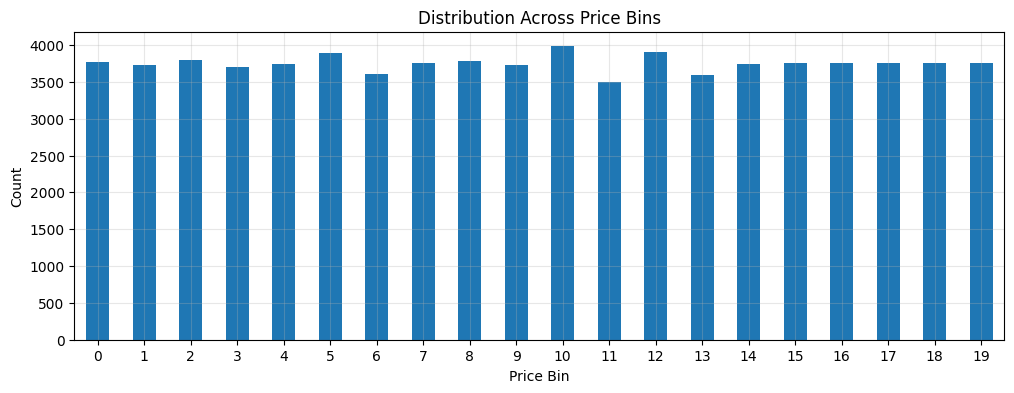


Weighted train loader created with 2344 batches
Use 'train_loader_weighted' instead of 'train_loader' in the training loop
This will oversample underrepresented price ranges during training


In [ ]:
from torch.utils.data import WeightedRandomSampler

def create_price_bins(prices, n_bins=20):
    bins = pd.qcut(prices, q=n_bins, labels=False, duplicates='drop')
    return bins

price_bins = create_price_bins(train_df['log_price'].values)

bin_counts = pd.Series(price_bins).value_counts().sort_index()
print("Price bin distribution:")
print(bin_counts)

plt.figure(figsize=(12, 4))
bin_counts.plot(kind='bar')
plt.title('Distribution Across Price Bins')
plt.xlabel('Price Bin')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3)
plt.show()

class_weights = 1.0 / bin_counts
class_weights = class_weights / class_weights.sum()

sample_weights = [class_weights[bin_counts.index.get_loc(bin_val)] for bin_val in price_bins]
sample_weights = np.array(sample_weights)

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

train_texts_full = train_df['clean_text'].values
train_prices_full = train_df['log_price'].values

train_dataset_weighted = ProductPriceDataset(
    train_texts_full,
    train_prices_full,
    tokenizer,
    MAX_LENGTH
)

train_loader_weighted = DataLoader(
    train_dataset_weighted,
    batch_size=BATCH_SIZE,
    sampler=sampler
)

print(f"\nWeighted train loader created with {len(train_loader_weighted)} batches")
print("Use 'train_loader_weighted' instead of 'train_loader' in the training loop")
print("This will oversample underrepresented price ranges during training")

Training 3 models for ensemble


Training Model 1/3 (Seed: 42)

Epoch 1/2


Validation: 100%|██████████| 235/235 [00:13<00:00, 17.85it/s]


Train Loss: 0.3676 | Train SMAPE: 36.76%
Val Loss: 0.2256 | Val SMAPE: 22.54%

Model 1 saved! Best Val SMAPE: 22.54%

Epoch 2/2


Validation: 100%|██████████| 235/235 [00:13<00:00, 17.80it/s]


Train Loss: 0.2260 | Train SMAPE: 22.60%
Val Loss: 0.2113 | Val SMAPE: 21.12%

Model 1 saved! Best Val SMAPE: 21.12%


Model 1 completed. Best Val SMAPE: 21.12%

Training Model 2/3 (Seed: 123)

Epoch 1/2


Validation: 100%|██████████| 235/235 [00:13<00:00, 17.80it/s]


Train Loss: 0.3513 | Train SMAPE: 35.13%
Val Loss: 0.2100 | Val SMAPE: 21.01%

Model 2 saved! Best Val SMAPE: 21.01%

Epoch 2/2


Validation: 100%|██████████| 235/235 [00:13<00:00, 17.80it/s]


Train Loss: 0.2242 | Train SMAPE: 22.42%
Val Loss: 0.2039 | Val SMAPE: 20.40%

Model 2 saved! Best Val SMAPE: 20.40%


Model 2 completed. Best Val SMAPE: 20.40%

Training Model 3/3 (Seed: 456)

Epoch 1/2


Validation: 100%|██████████| 235/235 [00:13<00:00, 17.77it/s]


Train Loss: 0.3564 | Train SMAPE: 35.64%
Val Loss: 0.2188 | Val SMAPE: 21.87%

Model 3 saved! Best Val SMAPE: 21.87%

Epoch 2/2


Validation: 100%|██████████| 235/235 [00:13<00:00, 17.80it/s]


Train Loss: 0.2260 | Train SMAPE: 22.60%
Val Loss: 0.2041 | Val SMAPE: 20.40%

Model 3 saved! Best Val SMAPE: 20.40%


Model 3 completed. Best Val SMAPE: 20.40%

All models trained!
Model 1 Best Val SMAPE: 21.12%
Model 2 Best Val SMAPE: 20.40%
Model 3 Best Val SMAPE: 20.40%

Generating predictions on test set...
Model 1 predicting...


Model 1: 100%|██████████| 2344/2344 [02:10<00:00, 17.90it/s]


Model 2 predicting...


Model 2: 100%|██████████| 2344/2344 [02:10<00:00, 17.91it/s]


Model 3 predicting...


Model 3: 100%|██████████| 2344/2344 [02:10<00:00, 17.91it/s]



All predictions shape: (3, 75000)
✓ Mean ensemble saved: test_out_ensemble_mean.csv
✓ Median ensemble saved: test_out_ensemble_median.csv

SMAPE-based weights: [0.32572347 0.3370948  0.33718173]
✓ Weighted ensemble saved: test_out_ensemble_weighted.csv

ENSEMBLE SUMMARY
Number of models: 3
Seeds used: [42, 123, 456]

Model weights (based on validation SMAPE):
  Model 1: Val SMAPE=21.12%, Weight=0.326
  Model 2: Val SMAPE=20.40%, Weight=0.337
  Model 3: Val SMAPE=20.40%, Weight=0.337

Ensemble predictions generated:
  1. Mean ensemble: test_out_ensemble_mean.csv
  2. Median ensemble: test_out_ensemble_median.csv
  3. Weighted ensemble: test_out_ensemble_weighted.csv (RECOMMENDED)


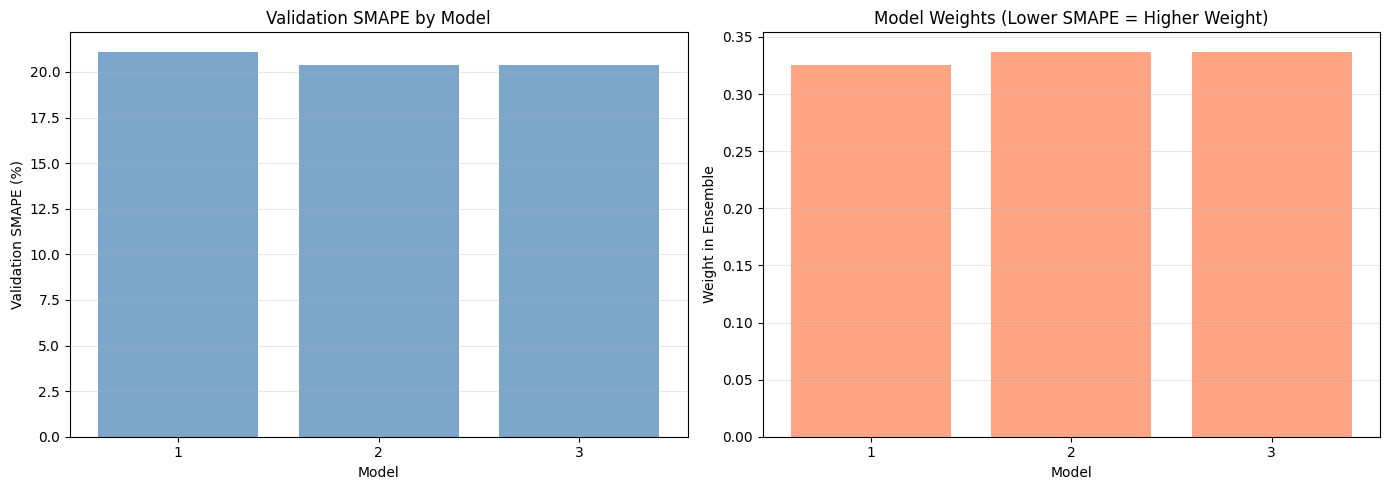

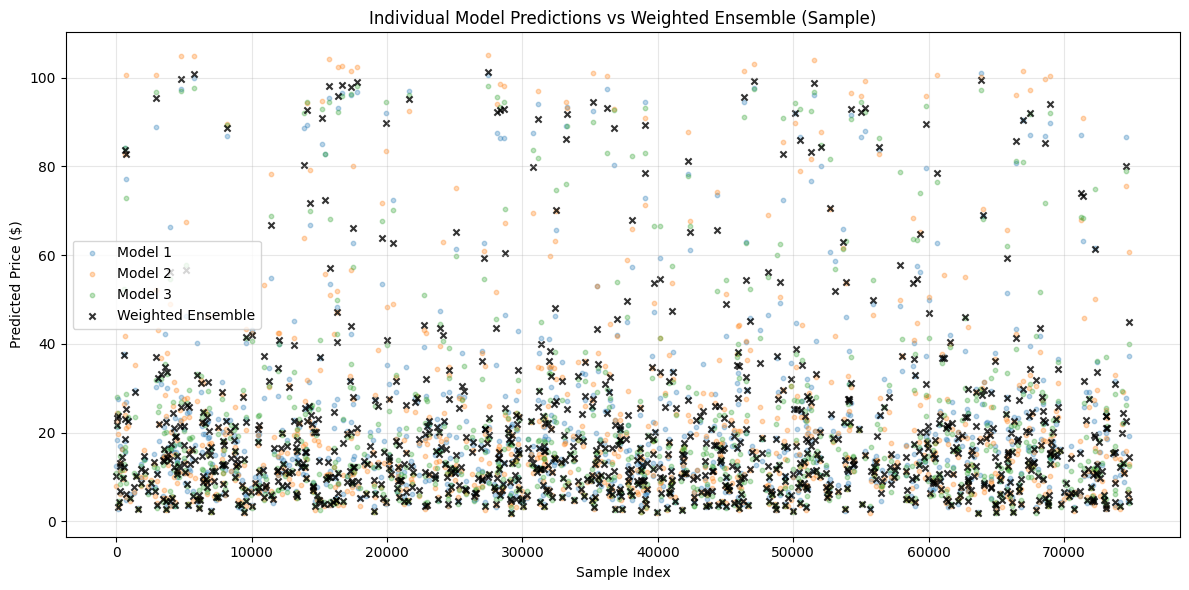


✓ Ensemble training and prediction completed!
Use 'test_out_ensemble_weighted.csv' for submission (best performance expected)


In [ ]:
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm

N_MODELS = 5
EPOCHS = 2
SEEDS = [42, 123, 456]

print(f"Training {N_MODELS} models for ensemble\n")

all_models = []
all_val_smapes = []

for model_idx in range(N_MODELS):
    print(f"\n{'='*60}")
    print(f"Training Model {model_idx+1}/{N_MODELS} (Seed: {SEEDS[model_idx]})")
    print(f"{'='*60}\n")

    torch.manual_seed(SEEDS[model_idx])
    np.random.seed(SEEDS[model_idx])

    from sklearn.model_selection import train_test_split
    train_texts, val_texts, train_prices, val_prices = train_test_split(
        train_df['clean_text'].values,
        train_df['log_price'].values,
        test_size=0.1,
        random_state=SEEDS[model_idx]
    )

    train_dataset = ProductPriceDataset(train_texts, train_prices, tokenizer, MAX_LENGTH)
    val_dataset = ProductPriceDataset(val_texts, val_prices, tokenizer, MAX_LENGTH)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    model = PricePredictionModel(AutoModel.from_pretrained(MODEL_NAME)).to(device)

    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
    total_steps = len(train_loader) * EPOCHS
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=WARMUP_STEPS,
        num_training_steps=total_steps
    )

    best_val_smape = float('inf')
    patience_counter = 0
    patience = 3

    for epoch in range(EPOCHS):
        print(f"Epoch {epoch+1}/{EPOCHS}")

        train_loss, train_smape = train_epoch(model, train_loader_weighted, optimizer, scheduler, device)
        val_loss, val_smape, _, _ = validate_epoch(model, val_loader, device)

        print(f"Train Loss: {train_loss:.4f} | Train SMAPE: {train_smape:.2f}%")
        print(f"Val Loss: {val_loss:.4f} | Val SMAPE: {val_smape:.2f}%\n")

        if val_smape < best_val_smape:
            best_val_smape = val_smape
            torch.save(model.state_dict(), f'ensemble_model_{model_idx+1}.pt')
            print(f"Model {model_idx+1} saved! Best Val SMAPE: {best_val_smape:.2f}%\n")
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping for model {model_idx+1}")
                break

    model.load_state_dict(torch.load(f'ensemble_model_{model_idx+1}.pt'))
    all_models.append(model)
    all_val_smapes.append(best_val_smape)

    print(f"\nModel {model_idx+1} completed. Best Val SMAPE: {best_val_smape:.2f}%")

print(f"\n{'='*60}")
print("All models trained!")
print(f"{'='*60}")
for i, smape in enumerate(all_val_smapes):
    print(f"Model {i+1} Best Val SMAPE: {smape:.2f}%")
print(f"{'='*60}\n")

print("Generating predictions on test set...")

all_test_predictions = []

for model_idx, model in enumerate(all_models):
    print(f"Model {model_idx+1} predicting...")

    test_dataset = ProductPriceDataset(
        test_df['clean_text'].values,
        None,
        tokenizer,
        MAX_LENGTH
    )
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    model.eval()
    test_preds = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc=f"Model {model_idx+1}"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model(input_ids, attention_mask)
            test_preds.extend(outputs.cpu().numpy())

    all_test_predictions.append(np.array(test_preds))

all_test_predictions = np.array(all_test_predictions)
print(f"\nAll predictions shape: {all_test_predictions.shape}")

ensemble_mean = np.mean(all_test_predictions, axis=0)
ensemble_mean_original = np.expm1(ensemble_mean)
ensemble_mean_original = np.maximum(ensemble_mean_original, 0.01)

submission_mean = pd.DataFrame({
    'sample_id': test_df['sample_id'],
    'price': ensemble_mean_original
})
submission_mean.to_csv('test_out_ensemble_mean.csv', index=False)
print("✓ Mean ensemble saved: test_out_ensemble_mean.csv")

ensemble_median = np.median(all_test_predictions, axis=0)
ensemble_median_original = np.expm1(ensemble_median)
ensemble_median_original = np.maximum(ensemble_median_original, 0.01)

submission_median = pd.DataFrame({
    'sample_id': test_df['sample_id'],
    'price': ensemble_median_original
})
submission_median.to_csv('test_out_ensemble_median.csv', index=False)
print("✓ Median ensemble saved: test_out_ensemble_median.csv")

smape_weights = 1.0 / np.array(all_val_smapes)
smape_weights = smape_weights / smape_weights.sum()

print(f"\nSMAPE-based weights: {smape_weights}")

ensemble_weighted = np.average(all_test_predictions, axis=0, weights=smape_weights)
ensemble_weighted_original = np.expm1(ensemble_weighted)
ensemble_weighted_original = np.maximum(ensemble_weighted_original, 0.01)

submission_weighted = pd.DataFrame({
    'sample_id': test_df['sample_id'],
    'price': ensemble_weighted_original
})
submission_weighted.to_csv('test_out_ensemble_weighted.csv', index=False)
print("✓ Weighted ensemble saved: test_out_ensemble_weighted.csv")

print(f"\n{'='*60}")
print("ENSEMBLE SUMMARY")
print(f"{'='*60}")
print(f"Number of models: {N_MODELS}")
print(f"Seeds used: {SEEDS}")
print(f"\nModel weights (based on validation SMAPE):")
for i, (smape, weight) in enumerate(zip(all_val_smapes, smape_weights)):
    print(f"  Model {i+1}: Val SMAPE={smape:.2f}%, Weight={weight:.3f}")
print(f"\nEnsemble predictions generated:")
print(f"  1. Mean ensemble: test_out_ensemble_mean.csv")
print(f"  2. Median ensemble: test_out_ensemble_median.csv")
print(f"  3. Weighted ensemble: test_out_ensemble_weighted.csv (RECOMMENDED)")
print(f"{'='*60}")

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(range(1, N_MODELS+1), all_val_smapes, alpha=0.7, color='steelblue')
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Validation SMAPE (%)')
axes[0].set_title('Validation SMAPE by Model')
axes[0].set_xticks(range(1, N_MODELS+1))
axes[0].grid(True, alpha=0.3, axis='y')

axes[1].bar(range(1, N_MODELS+1), smape_weights, alpha=0.7, color='coral')
axes[1].set_xlabel('Model')
axes[1].set_ylabel('Weight in Ensemble')
axes[1].set_title('Model Weights (Lower SMAPE = Higher Weight)')
axes[1].set_xticks(range(1, N_MODELS+1))
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

sample_indices = np.random.choice(len(test_df), size=min(1000, len(test_df)), replace=False)

fig, ax = plt.subplots(figsize=(12, 6))

for i in range(N_MODELS):
    preds_original = np.expm1(all_test_predictions[i][sample_indices])
    ax.scatter(sample_indices, preds_original, alpha=0.3, s=10, label=f'Model {i+1}')

ensemble_sample = ensemble_weighted_original[sample_indices]
ax.scatter(sample_indices, ensemble_sample, alpha=0.8, s=20, color='black',
           marker='x', label='Weighted Ensemble')

ax.set_xlabel('Sample Index')
ax.set_ylabel('Predicted Price ($)')
ax.set_title('Individual Model Predictions vs Weighted Ensemble (Sample)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✓ Ensemble training and prediction completed!")
print("Use 'test_out_ensemble_weighted.csv' for submission (best performance expected)")